In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from spectral import SpectralNorm
import numpy as np
from torchsummary import summary
from tensorboardX import SummaryWriter

In [2]:
torch.cuda.is_available()

True

In [3]:
!which python

/opt/anaconda3/envs/fastai/bin/python


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
device

'cuda'

In [6]:
import os
import time
import torch
import datetime
import itertools

import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from tensorboardX import SummaryWriter

from alphagan_models import Generator, Discriminator, Encoder, Codecriminator
from utils import *

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
import tester
from data_loader import Data_Loader
from utils import denorm

In [8]:
batch_size = 64
G = Generator(batch_size, 64, 128, 64).to(device)
E = Encoder(batch_size, 64, 128, 64).to(device)
D = Discriminator(batch_size, 128, 64).to(device)

In [17]:
ds = Data_Loader(True, 'mura', 'XR_SHOULDER', '', '/home/phuc/datasets/', 64, 64)
dl = ds.loader()

Dataset lengh:  8379


In [52]:
model_save_path = 'models/alpha_shoulder1/52800'
G.load_state_dict(torch.load(model_save_path + '_G.pth'))
E.load_state_dict(torch.load(model_save_path + '_E.pth'))
D.load_state_dict(torch.load(model_save_path + '_D.pth'))
print('loaded trained models (step: {})..!'.format(model_save_path))

loaded trained models (step: models/alpha_shoulder1/52800)..!


In [53]:
data_iter = iter(dl)
with torch.no_grad(): 
    l1 = []
    l2 = []
    ld = []
    ld5 = []
    ld4 = []
    ld3 = []
    labels = []
    
    for i, data in enumerate(data_iter):
        val_images, val_labels = data
        val_images = tensor2var(val_images)
        labels.append(val_labels)

        # Run val images through models X -> E(X) -> G(E(X))
        mean_z, mean_logvar, ef1, ef2 = E(val_images)
        z = mean_z + mean_logvar * torch.randn(mean_z.size()).cuda()
        rec_images, gf1, gf2 = G(z)

        d_real, d_real4, d_real3 = D(val_images)
        d_rec, d_rec4, d_rec3 = D(rec_images)

        # Compute residual loss 
        l1.append((val_images - rec_images).abs().view(val_images.size(0), -1).mean(dim=-1))
        l2.append((val_images - rec_images).pow(2).sqrt().view(val_images.size(0), -1).mean(dim=-1))
        # Computer feature matching loss
        ld.append((d_real - d_rec).view((d_real.size(0), -1)).mean(dim=1))
        ld4.append((d_real4 - d_rec4).view((d_real4.size(0), -1)).mean(dim=1))
        ld3.append((d_real3 - d_rec3).view((d_real3.size(0), -1)).mean(dim=1))

    l1 = np.stack(torch.cat(l1).cpu().data)
    l2 = np.stack(torch.cat(l2).cpu().data)
    ld = np.stack(torch.cat(ld).cpu().data)
    ld4 = np.stack(torch.cat(ld4).cpu().data)
    ld3 = np.stack(torch.cat(ld3).cpu().data)
    labels = np.stack(torch.cat(labels).cpu().data)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


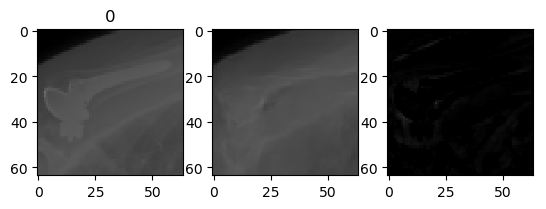

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


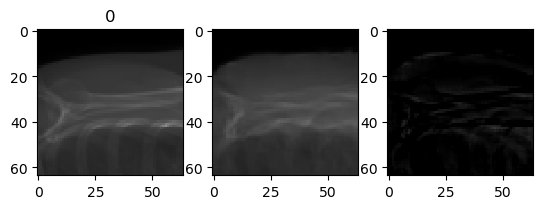

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


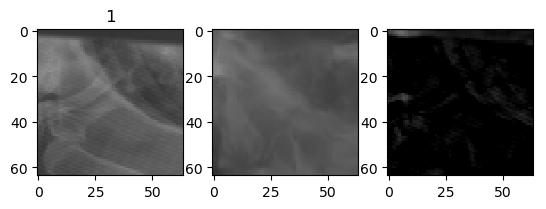

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


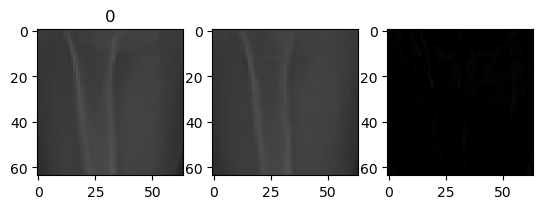

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


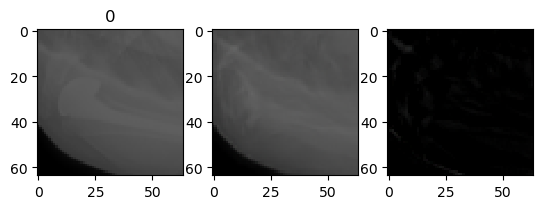

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


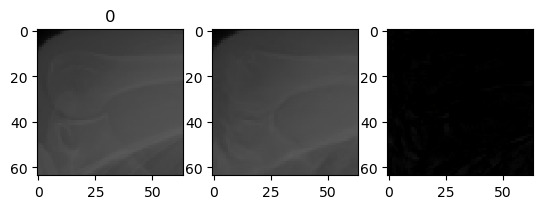

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


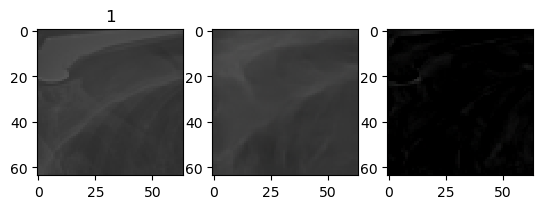

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


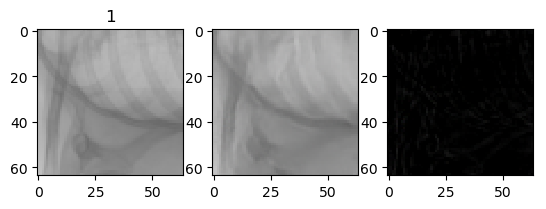

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


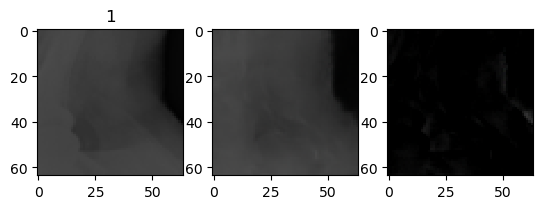

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


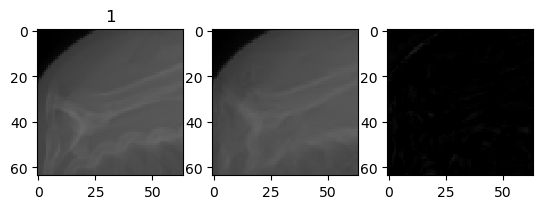

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


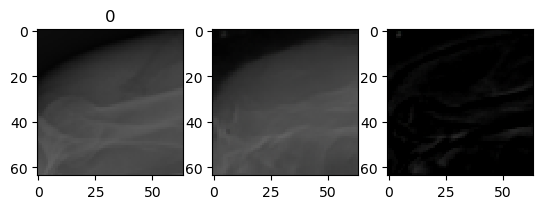

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


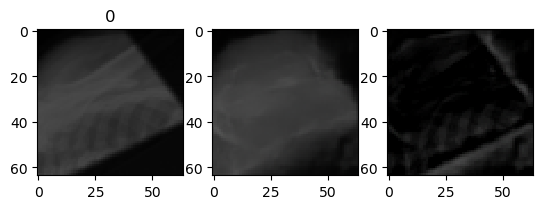

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


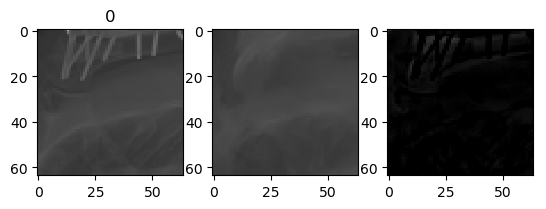

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


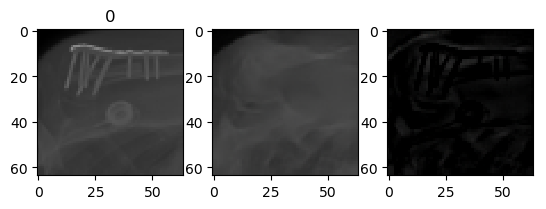

KeyboardInterrupt: 

In [54]:
for i in range(val_images.size(0)):
    plt.subplot(131)
    plt.imshow(denorm(val_images[i]).transpose(0,2))
    plt.title(labels[i])
    plt.subplot(132)
    plt.imshow(denorm(rec_images[i]).transpose(0,2))
    plt.subplot(133)
    plt.imshow(((rec_images[i]-val_images[i])).transpose(0,2))
    plt.show()
    input("Press Enter to continue...") 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


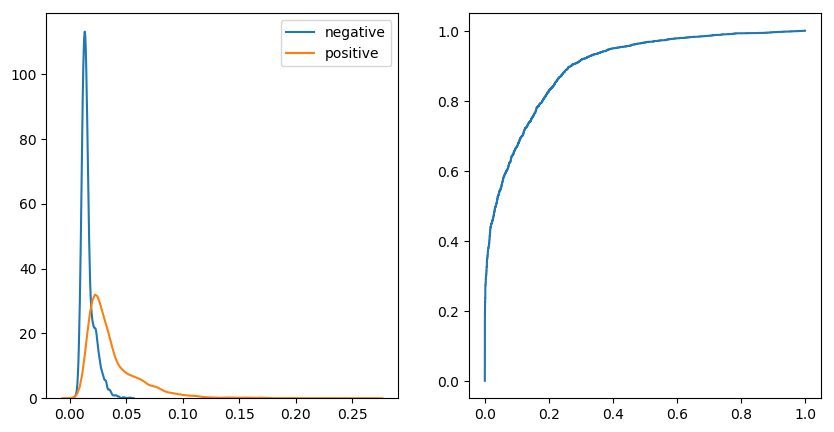

In [55]:
plt.style.use('default')
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(l1[labels==0], hist=False, label='negative')
sns.distplot(l1[labels==1], hist=False, label='positive')
plt.subplot(122)
fpr, tpr, thresh = roc_curve(labels, l1)
plt.plot(fpr, tpr)

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


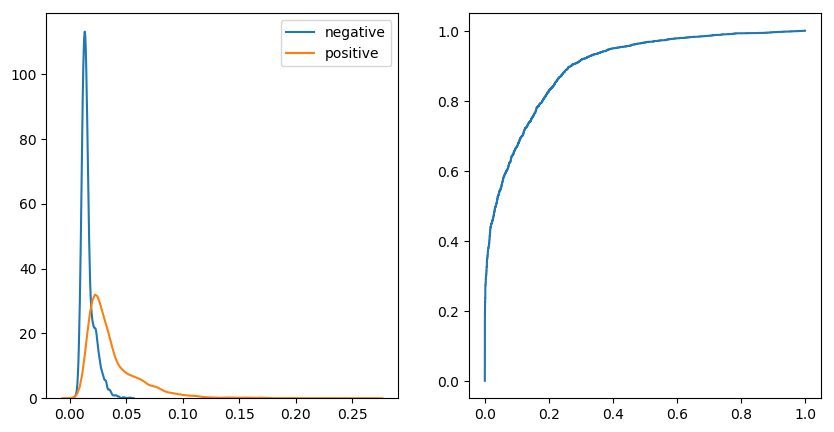

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(l2[labels==0], hist=False, label='negative')
sns.distplot(l2[labels==1], hist=False, label='positive')
plt.subplot(122)
fpr, tpr, thresh = roc_curve(labels, l2)
plt.plot(fpr, tpr)

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


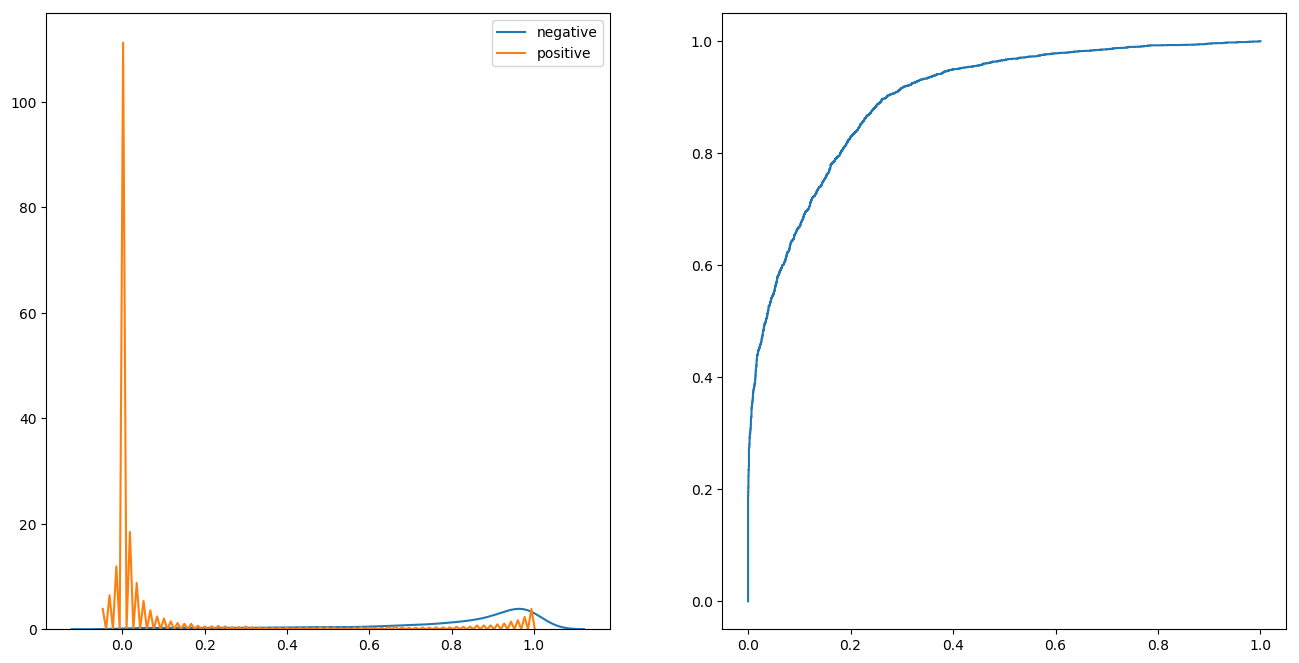

In [57]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
sns.distplot(ld[labels==0], hist=False, label='negative')
sns.distplot(ld[labels==1], hist=False, label='positive')
plt.subplot(122)
fpr, tpr, thresh = roc_curve(labels, l2)
plt.plot(fpr, tpr)

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


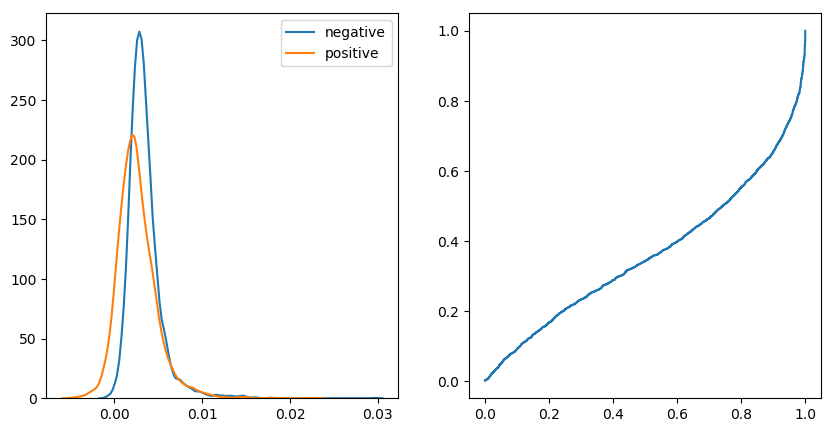

In [58]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(ld4[labels==0], hist=False, label='negative')
sns.distplot(ld4[labels==1], hist=False, label='positive')
plt.subplot(122)
fpr, tpr, thresh = roc_curve(labels, ld4)
plt.plot(fpr, tpr)

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


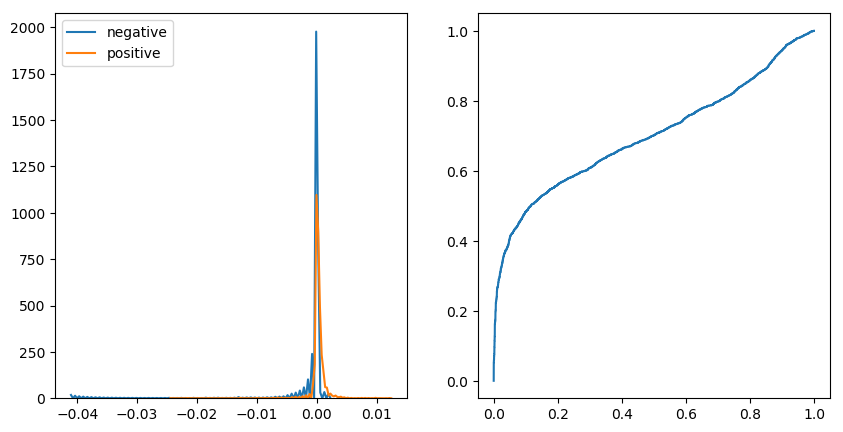

In [59]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(ld3[labels==0], hist=False, label='negative')
sns.distplot(ld3[labels==1], hist=False, label='positive')
plt.subplot(122)
fpr, tpr, thresh = roc_curve(labels, ld3)
plt.plot(fpr, tpr)